In [1]:
from datasetcontroller.datacontroller import DataController
import os
import tensorflow as tf
from nnmodules.unet import Unet_v3
import matplotlib.pyplot as plt

2023-05-26 01:34:15.193203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 01:34:15.296298: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
BATCH_SIZE = 8
train_set_len = 100
shuffle_buffer_size = 100

def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(8, 8))
  # display_list = [test_input[0][0][:,:,:3], tar[0][:,:,0][::-1], prediction[0][::-1]]
  # title = ['Input', 'Ground Truth', 'Predicted Image']
  print(prediction.shape, tar.shape)
  display_list = [tar[0][::-1], prediction[0][::-1]]
  title = ['Ground Truth', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

* 데이터셋

In [3]:
# 데이터셋 폴더 경로 설정
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

# 모델 체크포인트
proj_path = os.path.join(path,'repos','cmaqProject')
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_4_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 컨트롤러
datacontroller = DataController(data_path = data_path)

# 기본 control matrix, smoke, cmaq 데이터셋 
control_matrix, smoke_arr, target_arr = datacontroller.get_yearly_dataset()

# 학습용셋
train_input = control_matrix[:train_set_len]
test_input = control_matrix[train_set_len:]

train_output = target_arr[:train_set_len]
test_output = target_arr[train_set_len:]

train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)

test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)


train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
test_ds = tf.data.Dataset.zip((test_input_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)


/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/datasetcontroller/datacontroller.py:54: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')
2023-05-26 01:34:19.684452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
# 1번 시나리오 베이스맵으로 사용
base_map = target_arr[0]
## 모델 체크포인트 생성
optimizer = tf.keras.optimizers.Adam(0.001)
unet = Unet_v3(base_map)
unet.compile()

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 unet=unet,
                                 )

####### 저장된 모델 있을 경우 ##########
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)

* 시도기반 맵

2023-05-26 01:34:23.548480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


20/20 [==============================] - 3s 9ms/step


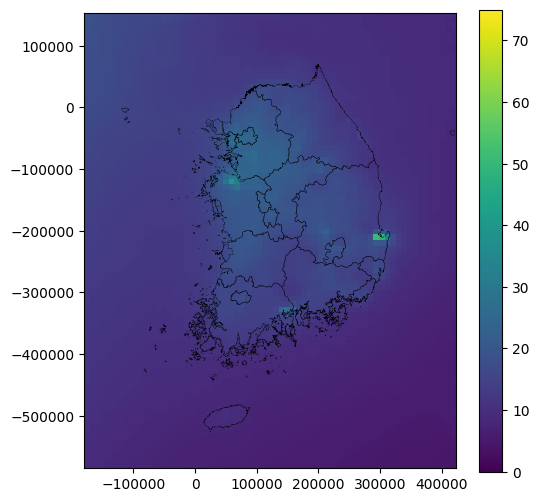

In [5]:
pred_test = unet.predict(test_input, batch_size = 1)
plot = datacontroller.get_ctp_based_pred_map(pred_arr = pred_test[0][::-1])

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


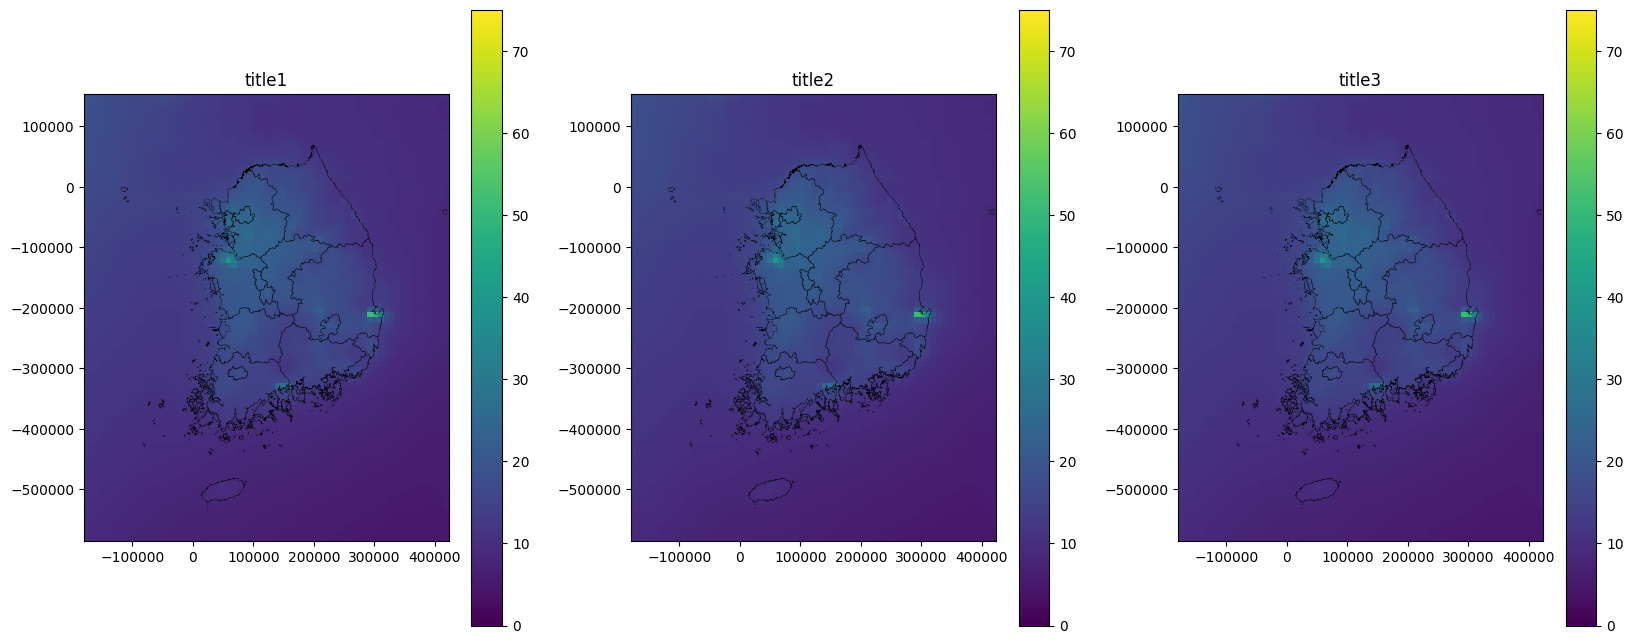

In [15]:
from rasterio.transform import from_origin
import rasterio
from rasterio.plot import show
from shapely.geometry import Point, Polygon
import geopandas as gpd

# 시도 정보 쉐이프파일
ctp_rvn_gpd = gpd.GeoDataFrame.from_file(os.path.join(data_path,"geoinfodata","시도","ctp_rvn.shp",),encoding = 'cp949')
ctp_rvn_gpd.crs = {'init':'epsg:5179'}

projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

cutting_polygon_coords = [(-180000, -550000), (-180000, 130000), (420000, 130000), (420000, -550000)]
cutting_polygon = Polygon(cutting_polygon_coords)
ctp_rvn_gpd_cutting = ctp_rvn_gpd.to_crs(projout).intersection(cutting_polygon)


data = pred_test[0][::-1] 
# 배열 크기
height, width, bands = data.shape

# 레스터 파일 생성
dst_filename = os.path.join(data_path,"output.tif")  # 저장할 레스터 파일 경로와 이름 설정
driver = 'GTiff'  # 레스터 파일 포맷 (여기서는 GeoTIFF로 설정)

# 레스터 파일 매개변수 설정
transform = from_origin(-180000, 153000, 9000, 9000)  # 좌표변환을 위한 transform 설정 (여기서는 임의로 설정)
# transform = from_origin(153000, -180000, 9000, 9000)  # 좌표변환을 위한 transform 설정 (여기서는 임의로 설정)
count = bands  # 밴드 개수
dtype = data.dtype  # 데이터 타입

# 레스터 파일 생성 및 데이터 쓰기
with rasterio.open(dst_filename, 'w', driver=driver, height=height, width=width, count=count, dtype=dtype, transform=transform) as dst:
    for band in range(bands):
        dst.write(data[:, :, band], band + 1)


with rasterio.open(dst_filename) as src:
    ax = plt.figure(figsize=(20, 8))
    # fig, ax = plt.subplots(figsize=(6, 6))
    ax1 = plt.subplot(1,3,1)
    plt.title('title1')
    data = src.read(1)
    # 컬러바
    image = ax1.imshow(data, vmin=0, vmax=75)
    cbar = plt.colorbar(image, ax=ax1,)

    # # 진짜 그리기
    image = show(src, ax=ax1, vmin=0, vmax=75)
    ctp_rvn_gpd_cutting.plot(ax=ax1, color='none', edgecolor='black', linewidth=0.2)
    
    ax2 = plt.subplot(1,3,2)
    plt.title('title2')
    data = src.read(1)
    # 컬러바
    image = ax2.imshow(data, vmin=0, vmax=75)
    cbar = plt.colorbar(image, ax=ax2,)

    # # 진짜 그리기
    image = show(src, ax=ax2, vmin=0, vmax=75)
    ctp_rvn_gpd_cutting.plot(ax=ax2, color='none', edgecolor='black', linewidth=0.2)
    
    ax3 = plt.subplot(1,3,3)
    plt.title('title3')
    data = src.read(1)
    # 컬러바
    image = ax3.imshow(data, vmin=0, vmax=75)
    cbar = plt.colorbar(image, ax=ax3,)

    # # 진짜 그리기
    image = show(src, ax=ax3, vmin=0, vmax=75)
    ctp_rvn_gpd_cutting.plot(ax=ax3, color='none', edgecolor='black', linewidth=0.2)
 
